In [17]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# hyper-parameter
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
INIT_LR = 1e-4
EPOCHS = 50

base_dir = "RealWaste_split"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data enhancer
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,     # Random rotation
    width_shift_range=0.2, # Horizontal translation
    height_shift_range=0.2,
    shear_range=0.2,      
    zoom_range=0.2,        # Random Resize
    horizontal_flip=True,  # flip horizontal

    fill_mode='nearest'
)

# Validation sets and test sets can be easily normalized without large-scale data enhancement

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate training, validation, and test iterators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Suppose it is multi-class, with category >2
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)


Found 1841 images belonging to 4 classes.
Found 523 images belonging to 4 classes.
Found 267 images belonging to 4 classes.


In [18]:
from tensorflow.keras import layers, models, Input, callbacks

num_classes = train_generator.num_classes  

# The number of categories automatically recognized by train_generator

model = models.Sequential([
    # The 1st convolution block
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # The 2nd convolution block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # The third convolution block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #  can add more layers
 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Prevent overfitting 
    layers.Dense(num_classes, activation='softmax')  # Prevent overfitting
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7
)


In [20]:
EPOCHS = 40  # Debuggability
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, lr_scheduler],
)


Epoch 1/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 513ms/step - accuracy: 0.3385 - loss: 1.6425 - val_accuracy: 0.4302 - val_loss: 1.2685 - learning_rate: 0.0010
Epoch 2/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 505ms/step - accuracy: 0.3988 - loss: 1.2947 - val_accuracy: 0.4685 - val_loss: 1.3202 - learning_rate: 0.0010
Epoch 3/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - accuracy: 0.5214 - loss: 1.1537 - val_accuracy: 0.5966 - val_loss: 1.0220 - learning_rate: 0.0010
Epoch 4/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 508ms/step - accuracy: 0.5509 - loss: 1.0592 - val_accuracy: 0.6042 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 5/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - accuracy: 0.6174 - loss: 0.9634 - val_accuracy: 0.5966 - val_loss: 1.0498 - learning_rate: 0.0010
Epoch 6/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accuracy: 0.6196 - loss: 0.9644 - val_accuracy: 0.6329 - val_loss: 0.9122 - learning_rate: 0.0010
Epoch 7/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 508ms/step - accuracy: 0.6256 - loss: 0.

In [21]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7163 - loss: 0.5898
Test Loss: 0.5293232798576355
Test Accuracy: 0.7640449404716492


In [22]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted value (on the test set)
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get real tags
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
              precision    recall  f1-score   support

       glass       0.94      0.72      0.82        43
       metal       0.77      0.62      0.69        80
       paper       0.79      0.86      0.82        51
     plastic       0.70      0.85      0.77        93

    accuracy                           0.76       267
   macro avg       0.80      0.76      0.77       267
weighted avg       0.78      0.76      0.76       267



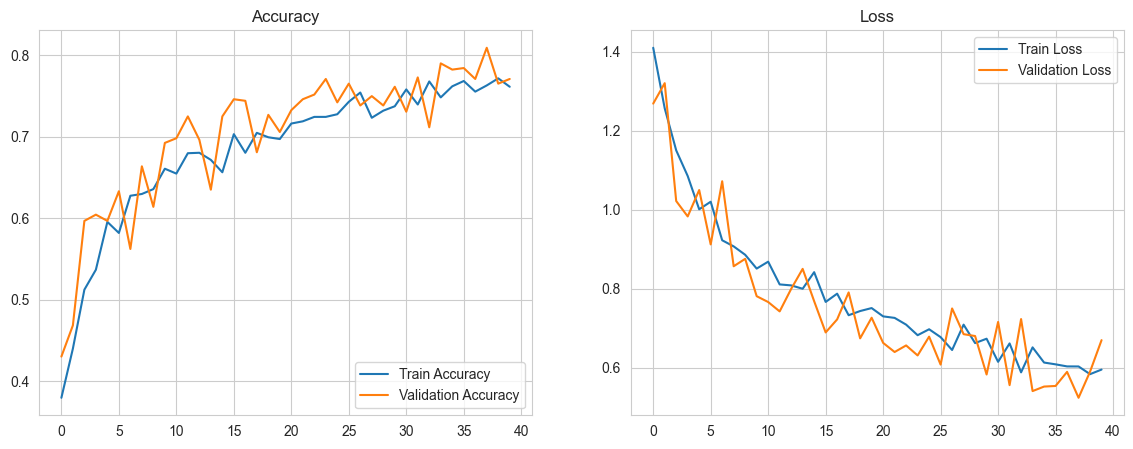

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


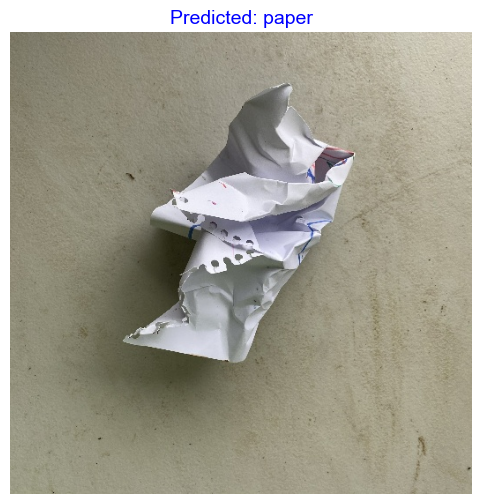

The image E:\somepc\myGr\CNNwaste\testfig\test_3.jpg predicted result is: paper


In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image

IMG_HEIGHT = 224
IMG_WIDTH = 224


class_names = ["glass", "metal", "paper", "plastic"]
img_path = r"E:\somepc\myGr\CNNwaste\testfig\test_3.jpg"


img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  

predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_index]

plt.figure(figsize=(6,6))
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Predicted: {predicted_class}", fontsize=14, color='blue')
plt.show()

print(f"The image {img_path} predicted result is: {predicted_class}")
# model.save("my_cnn_model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


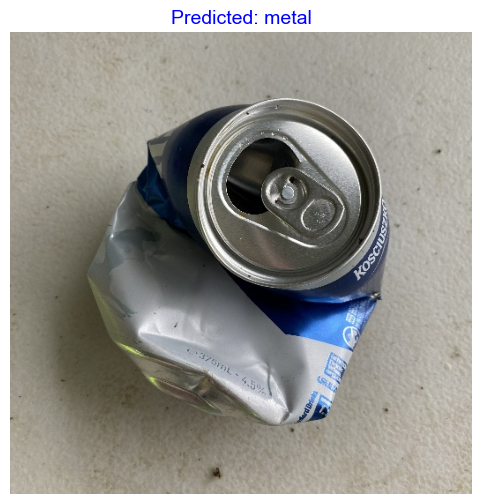

The image E:\somepc\myGr\CNNwaste\testfig\test_13.jpg predicted result is: metal


In [25]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# class name
class_names = ["glass", "metal", "paper", "plastic"]


img_path_a = r"E:\somepc\myGr\CNNwaste\testfig\test_13.jpg"

# Read and scale
img = image.load_img(img_path_a, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0 

# make a prediction
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_index]

plt.figure(figsize=(6,6))
plt.imshow(image.load_img(img_path_a))  
plt.axis('off')  # not display coordinate axes
plt.title(f"Predicted: {predicted_class}", fontsize=14, color='blue')
plt.show()

print(f"The image {img_path_a} predicted result is: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


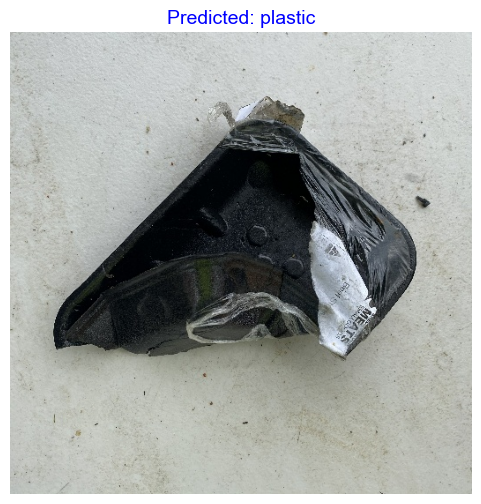

The image E:\somepc\myGr\CNNwaste\testfig\test_92.jpg predicted result is: plastic


In [26]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# class name
class_names = ["glass", "metal", "paper", "plastic"]


img_path_b = r"E:\somepc\myGr\CNNwaste\testfig\test_92.jpg"

# Read and scale
img = image.load_img(img_path_b, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  

# Make predictions
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_index]

plt.figure(figsize=(6,6))
plt.imshow(image.load_img(img_path_b)) 
plt.axis('off') 
plt.title(f"Predicted: {predicted_class}", fontsize=14, color='blue')
plt.show()

print(f"The image {img_path_b} predicted result is: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


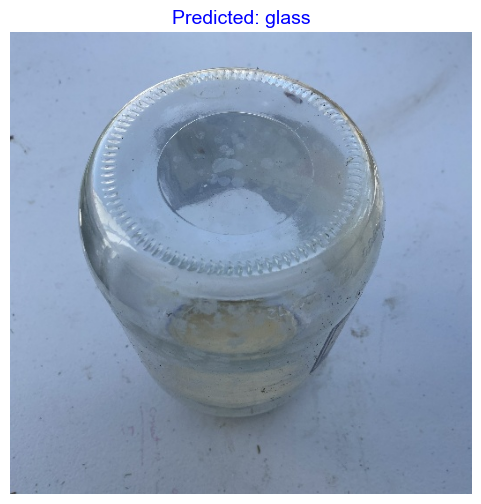

The image E:\somepc\myGr\CNNwaste\testfig\test_253.jpg predicted result is: glass


In [34]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# class names
class_names = ["glass", "metal", "paper", "plastic"]


img_path_c = r"E:\somepc\myGr\CNNwaste\testfig\test_253.jpg"

# Read and scale
img = image.load_img(img_path_c, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0 

# make a prediction
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_index]

plt.figure(figsize=(6,6))
plt.imshow(image.load_img(img_path_c))  # Load the artwork directly
plt.axis('off')  # not display coordinate axes
plt.title(f"Predicted: {predicted_class}", fontsize=14, color='blue')
plt.show()

print(f"The image {img_path_c} predicted result is: {predicted_class}")